In [1]:
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

# Data Pre-Processing functions

NOTE TO SELF: Use boolean masking to cut dataframes whenever possible -> much faster than pd.drop

In [2]:
def process_data(data_path, del_cols=[], cuts=True):
    """
    This functions reads and pre-processes all the data in the chosen data_path with pandas
    Cuts applied:
        - At least 2 Leptons
        - At least 1 FatJet
    
    data_path -> string: the path of the data to be acquired and pre-processed\n
    del_cols -> [string]: all columns to be deleted from the dataframe\n
    btag_cols -> [string]: list of columns referring to btag count\n
    lepton_cols -> [string]: list of columns referring to lepton count\n
    cut -> bool: whether or not cuts are to be applied to the data
    
    return -> pandas dataframe: pre-processed data
    """
    
    # Initializing variables
    data = []
    total_drop, total_len = 0, 0
    files = glob(data_path + "/*.csv")
    files += glob(data_path + "/*.h5")
    
    # Collect all data from path
    for file in tqdm(files, total=len(files), desc="Preprocessing Data"):
        # Read sample
        if file.endswith(".csv"): df = pd.read_csv(file)
        elif file.endswith(".h5"): df = pd.read_hdf(file)
        else: raise ValueError("Unrecognized file format")
            
        # Sort indices
        df.sort_index(inplace=True)
        
        # Get file sample
        sample = file.split("/")[-1].split(".")[0]
        if "train" in sample: sample = sample.replace("_train", "")
        elif "test" in sample: sample = sample.replace("_test", "")
        
        # Apply cuts
        if cuts:
            len_inc = df.shape[0]
            total_len += len_inc
            df = df[df["Electron_Multi"] + df["Muon_Multi"] > 1] # At least 2 leptons
            df = df[df["FatJet_Multi"] > 0] # At least 1 FatJet
            tqdm.write(f" Sample: {sample} | Original Size: {len_inc} | Drop_Ratio: {(len_inc - df.shape[0])/len_inc:.3f}")
            total_drop += len_inc - df.shape[0]
        
        # Delete columns
        df.drop([col for col in del_cols if col in df], axis=1, inplace=True)
        
        # Calculate gen_weights
        df["gen_xsec"] = df["gen_xsec"].mean() / df.shape[0]
        df.rename(columns={"gen_xsec":"gen_weights"}, inplace=True)
        
        # Add sample and label columns
        if file.split("/")[-2] == "dileptonic": df["Label"] = 0
        elif file.split("/")[-2] == "sm_gluon_vlq": df["Label"] = 1
        else: raise ValueError("Unrecognized data folder")
        df["Sample"] = sample
        
        data.append(df)
        
    # Concatenate data
    if len(data) > 1: data = pd.concat(data)
    else: data = data[0]
        
    if cuts: print(f"Total Drop Ratio: {total_drop/total_len:.3f}")
        
    return data

# Cut Testing

In [3]:
# Delete columns list
del_cols = ["gen_decay1", "gen_decay2", "gen_sample", "gen_filter", "gen_decay_filter", "MissingET_Eta"]

In [4]:
data_path = "data/dileptonic"
uncut_bkgd = process_data(data_path, del_cols, False)

Preprocessing Data: 100%|██████████| 18/18 [01:26<00:00,  4.81s/it]


In [5]:
data_path = "data/sm_gluon_vlq"
uncut_vlq = process_data(data_path, del_cols, False)

Preprocessing Data: 100%|██████████| 7/7 [00:17<00:00,  2.54s/it]


In [6]:
# Testing cut ratio
vlq_ratio = uncut_vlq[uncut_vlq["FatJet_Multi"] > 0]
vlq_ratio = vlq_ratio[vlq_ratio["Electron_Multi"] + vlq_ratio["Muon_Multi"] > 1].shape[0] / uncut_vlq.shape[0]
bkgd_ratio = uncut_bkgd[uncut_bkgd["FatJet_Multi"] > 0]
bkgd_ratio = bkgd_ratio[bkgd_ratio["Electron_Multi"] + bkgd_ratio["Muon_Multi"] > 1].shape[0] / uncut_bkgd.shape[0]

print(1 - vlq_ratio, 1 - bkgd_ratio)
print(vlq_ratio / bkgd_ratio)

0.9368655882352941 0.9732889312979927
2.3636048586839693


# Import Data

In [7]:
# PreProcess bkgd data
data_path = "data/dileptonic"
bkgd = process_data(data_path, del_cols)

Preprocessing Data:   6%|▌         | 1/18 [00:00<00:07,  2.29it/s]

 Sample: ttbarZ_2L | Original Size: 100000 | Drop_Ratio: 0.790


Preprocessing Data:  11%|█         | 2/18 [00:14<01:11,  4.47s/it]

 Sample: Zbj_2L | Original Size: 4000000 | Drop_Ratio: 0.987


Preprocessing Data:  17%|█▋        | 3/18 [00:26<01:41,  6.75s/it]

 Sample: Zbb_2L | Original Size: 4000000 | Drop_Ratio: 0.998


Preprocessing Data:  22%|██▏       | 4/18 [00:40<02:03,  8.83s/it]

 Sample: Zjj_2L | Original Size: 4000000 | Drop_Ratio: 0.986


Preprocessing Data:  28%|██▊       | 5/18 [00:41<01:26,  6.67s/it]

 Sample: ZZ_2L | Original Size: 500000 | Drop_Ratio: 0.985


Preprocessing Data:  33%|███▎      | 6/18 [00:41<00:56,  4.74s/it]

 Sample: ttbarZ_2L | Original Size: 50000 | Drop_Ratio: 0.792


Preprocessing Data:  39%|███▉      | 7/18 [00:42<00:37,  3.38s/it]

 Sample: topZj_2L | Original Size: 50000 | Drop_Ratio: 0.905


Preprocessing Data:  44%|████▍     | 8/18 [00:42<00:24,  2.43s/it]

 Sample: topWZ_2L | Original Size: 50000 | Drop_Ratio: 0.786


Preprocessing Data:  50%|█████     | 9/18 [00:42<00:15,  1.77s/it]

 Sample: topZj_2L | Original Size: 50000 | Drop_Ratio: 0.906


Preprocessing Data:  56%|█████▌    | 10/18 [00:42<00:10,  1.36s/it]

 Sample: ttbarW_2L | Original Size: 100000 | Drop_Ratio: 0.905


Preprocessing Data:  61%|██████    | 11/18 [00:43<00:07,  1.07s/it]

 Sample: topZj_2L | Original Size: 100000 | Drop_Ratio: 0.906


Preprocessing Data:  67%|██████▋   | 12/18 [00:45<00:07,  1.24s/it]

 Sample: WZ_2L | Original Size: 500000 | Drop_Ratio: 0.983


Preprocessing Data:  72%|███████▏  | 13/18 [00:59<00:26,  5.31s/it]

 Sample: ttbarb_2L | Original Size: 3899999 | Drop_Ratio: 0.968


Preprocessing Data:  78%|███████▊  | 14/18 [01:00<00:15,  3.79s/it]

 Sample: ttbarZ_2L | Original Size: 50000 | Drop_Ratio: 0.789


Preprocessing Data:  83%|████████▎ | 15/18 [01:02<00:09,  3.27s/it]

 Sample: ttbarH_2L | Original Size: 500000 | Drop_Ratio: 0.908


Preprocessing Data:  89%|████████▉ | 16/18 [01:03<00:05,  2.84s/it]

 Sample: ttbar_2L | Original Size: 500000 | Drop_Ratio: 0.964


Preprocessing Data:  94%|█████████▍| 17/18 [01:19<00:06,  6.66s/it]

 Sample: ttbarj_2L | Original Size: 4000000 | Drop_Ratio: 0.949


Preprocessing Data: 100%|██████████| 18/18 [01:21<00:00,  4.50s/it]

 Sample: WW_2L | Original Size: 500000 | Drop_Ratio: 0.991
Total Drop Ratio: 0.973


In [8]:
#Pre-Process VLQ data
data_path = "data/sm_gluon_vlq"
vlq = process_data(data_path, del_cols)

Preprocessing Data:  14%|█▍        | 1/7 [00:01<00:07,  1.23s/it]

 Sample: mch45_HG_13TeV_wohg_HQ1200 | Original Size: 250000 | Drop_Ratio: 0.938


Preprocessing Data:  29%|██▊       | 2/7 [00:02<00:06,  1.23s/it]

 Sample: mch45_HG_13TeV_wohg_HQ1200 | Original Size: 250000 | Drop_Ratio: 0.939


Preprocessing Data:  43%|████▎     | 3/7 [00:03<00:04,  1.23s/it]

 Sample: mch45_HG_13TeV_wohg_HQ1400 | Original Size: 250000 | Drop_Ratio: 0.941


Preprocessing Data:  57%|█████▋    | 4/7 [00:13<00:11,  3.67s/it]

 Sample: smg | Original Size: 1900000 | Drop_Ratio: 0.936


Preprocessing Data:  71%|███████▏  | 5/7 [00:14<00:05,  2.94s/it]

 Sample: mch45_HG_13TeV_wohg_HQ1000 | Original Size: 250000 | Drop_Ratio: 0.935


Preprocessing Data:  86%|████████▌ | 6/7 [00:15<00:02,  2.42s/it]

 Sample: mch45_HG_13TeV_wohg_HQ1000 | Original Size: 250000 | Drop_Ratio: 0.936


Preprocessing Data: 100%|██████████| 7/7 [00:16<00:00,  2.39s/it]

 Sample: mch45_HG_13TeV_wohg_HQ1400 | Original Size: 250000 | Drop_Ratio: 0.942
Total Drop Ratio: 0.937


In [9]:
print("VLQ Yield:", sum(vlq["gen_weights"].values) * 150)
print("Bkgd Yield:", sum(bkgd["gen_weights"].values) * 150)

VLQ Yield: 17.403385093552426
Bkgd Yield: 70915.78499044871


## Save Data

In [10]:
bkgd.to_hdf("data/preprocessed/bkgd.h5", key="bkgd")
vlq.to_hdf("data/preprocessed/vlq.h5", key="vlq")

# Plots

Plotting: 100%|██████████| 72/72 [04:29<00:00,  3.74s/it]


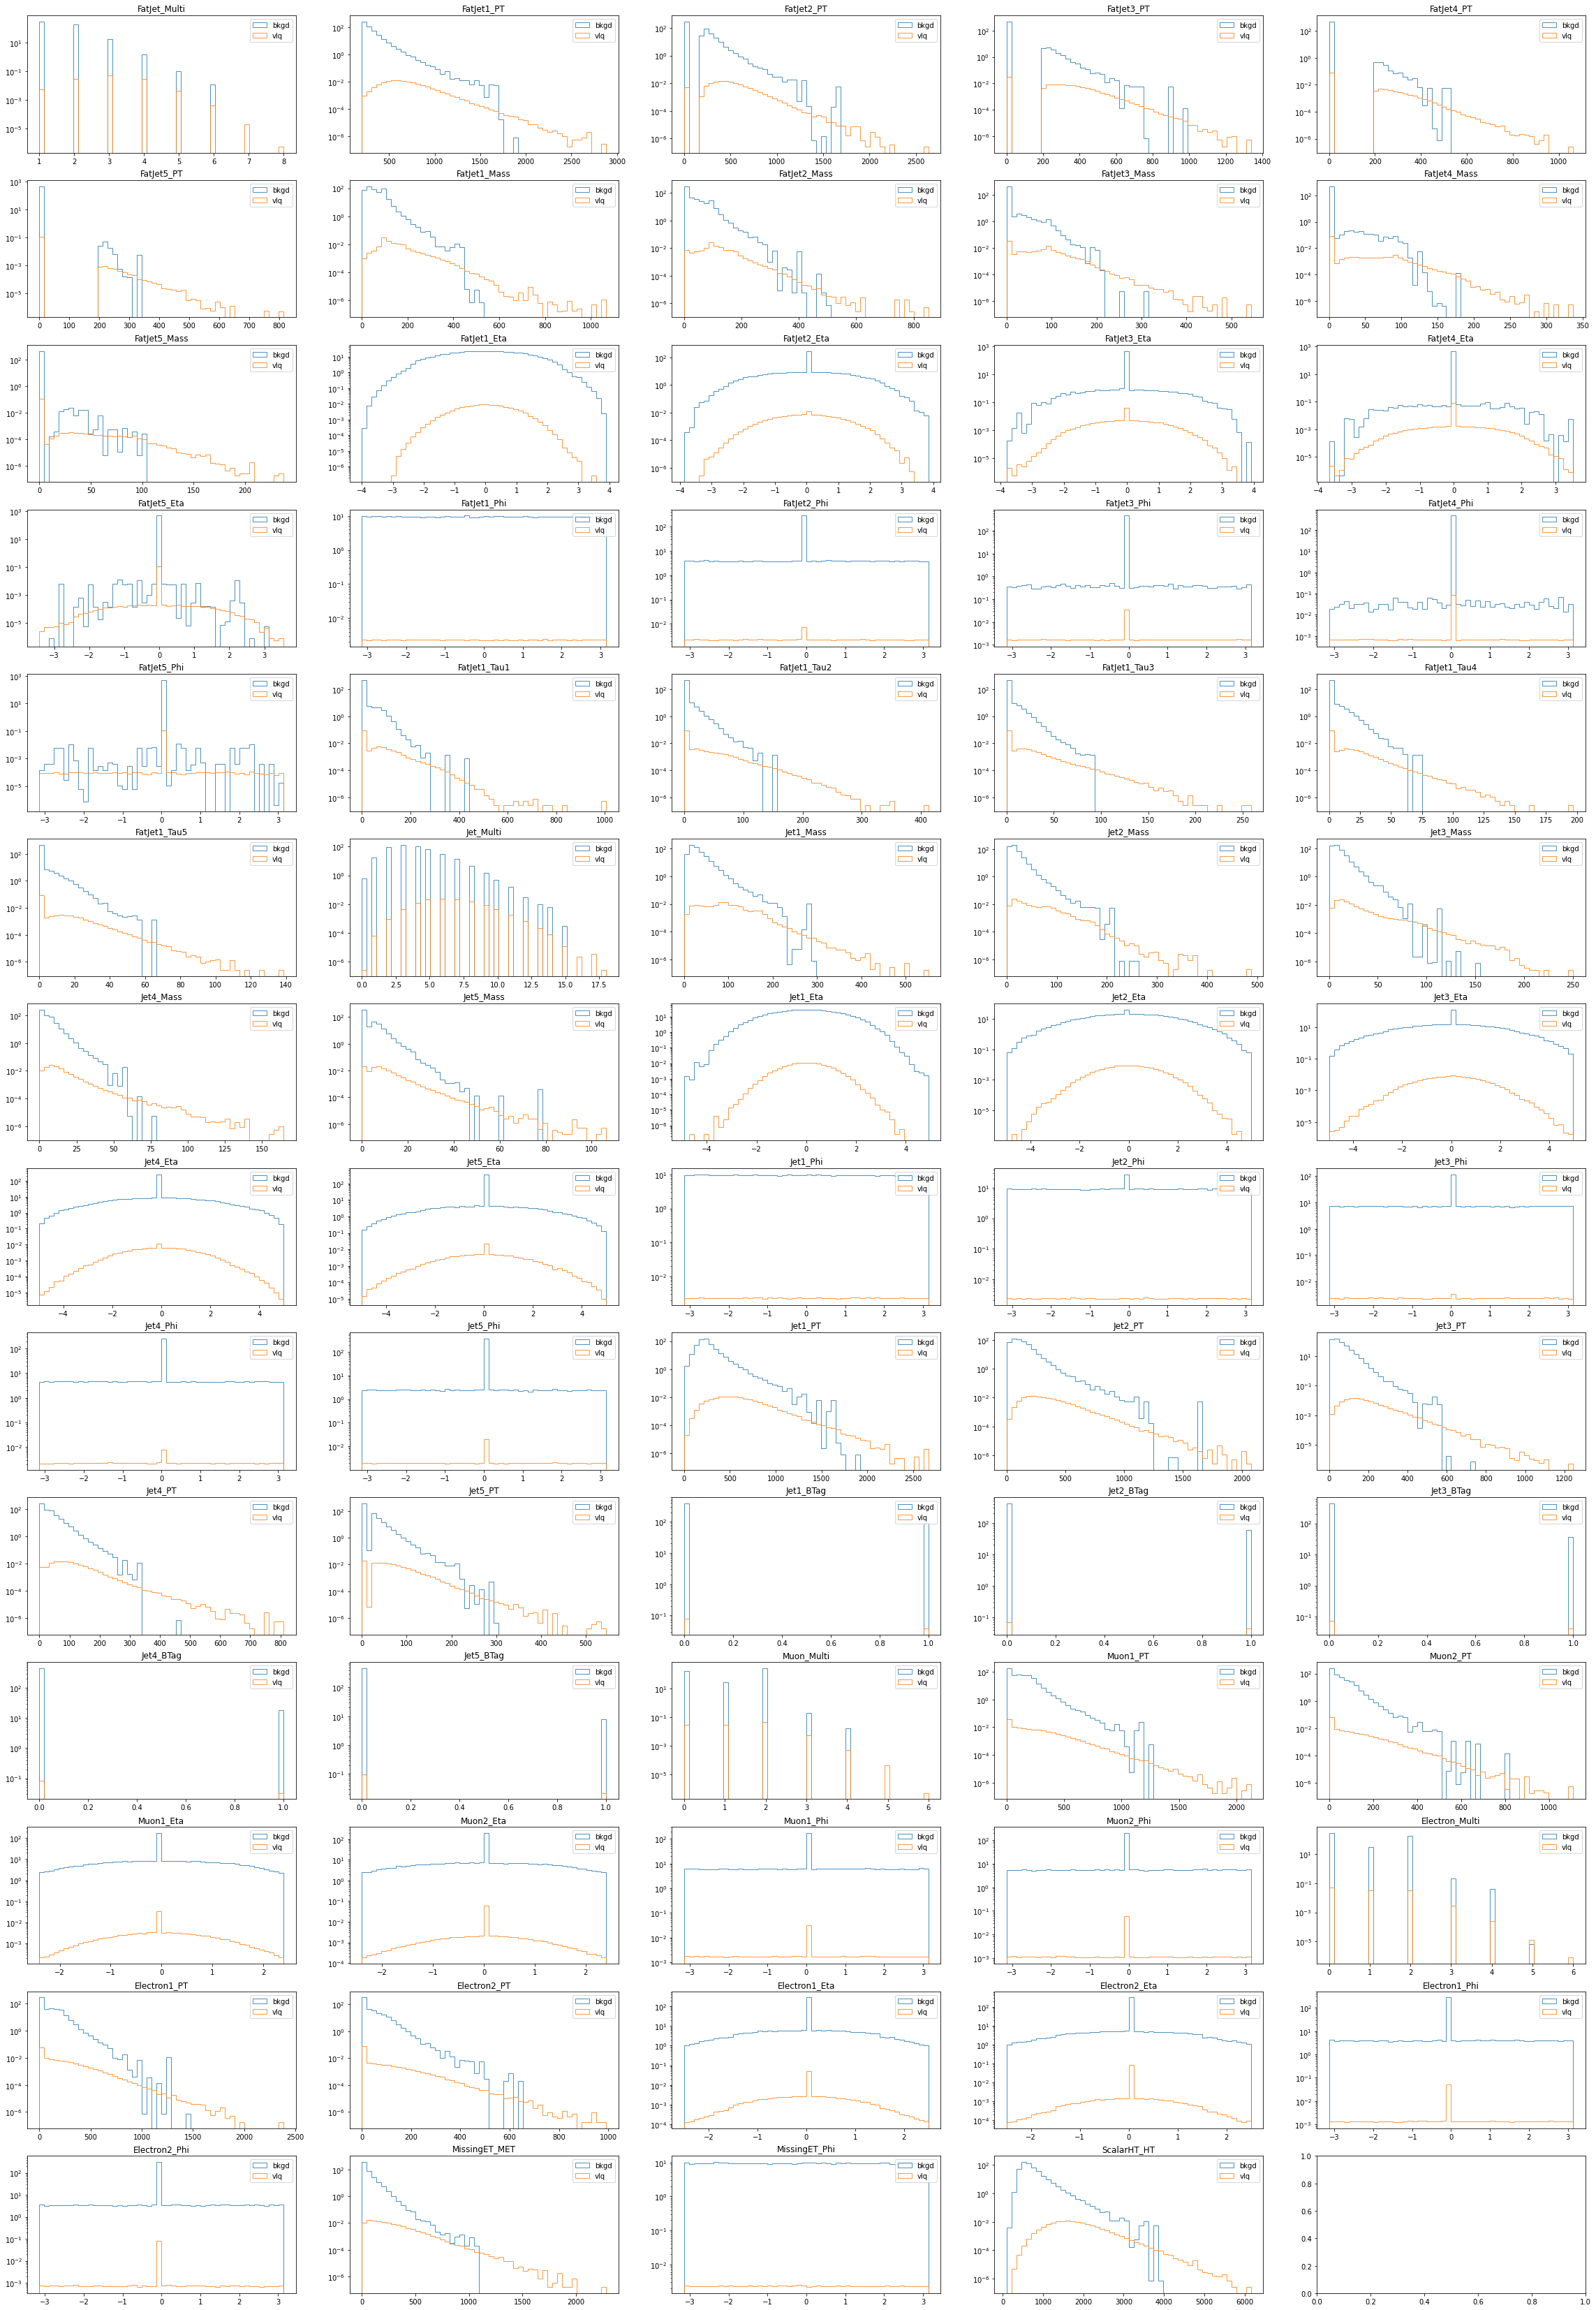

In [11]:
# Adjustment variables
num_cols, bins = 5, 50

# Create plots
num_rows = int(np.ceil((len(list(bkgd.columns)) - 2) / num_cols))
fig, axs = plt.subplots(num_rows, num_cols, figsize=(40, 60))

# Iterate and plot the data
ignore_cols = ["gen_weights", "Label", "Sample"]
for i, column in tqdm(enumerate(bkgd.columns), total=len(list(bkgd.columns)), desc="Plotting"):
    if vlq.columns[i] not in ignore_cols:
        # Define histogram range
        hist_min = min(vlq[column].min(), bkgd[column].min())
        hist_max = max(vlq[column].max(), bkgd[column].max())
        hist_range = (hist_min, hist_max)

        # Plot data
        row, col = int(i/num_cols), i%num_cols
        axs[row, col].set_title(vlq.columns[i])
        axs[row, col].hist(bkgd[column], bins=50, label="bkgd", alpha=0.8, range=hist_range,
                           weights=bkgd["gen_weights"], histtype='step')
        axs[row, col].hist(vlq[column], bins=50, label="vlq", alpha=0.8, range=hist_range,
                           weights=vlq["gen_weights"], histtype='step')
        axs[row, col].set_yscale("log")
        axs[row, col].legend()

plt.savefig("plots/VLQ_vs_BKGD_distributions.png", dpi=500)
plt.show()

## Plotting VLQ distributions before and after cuts

Plotting: 100%|██████████| 72/72 [19:45<00:00, 16.47s/it]


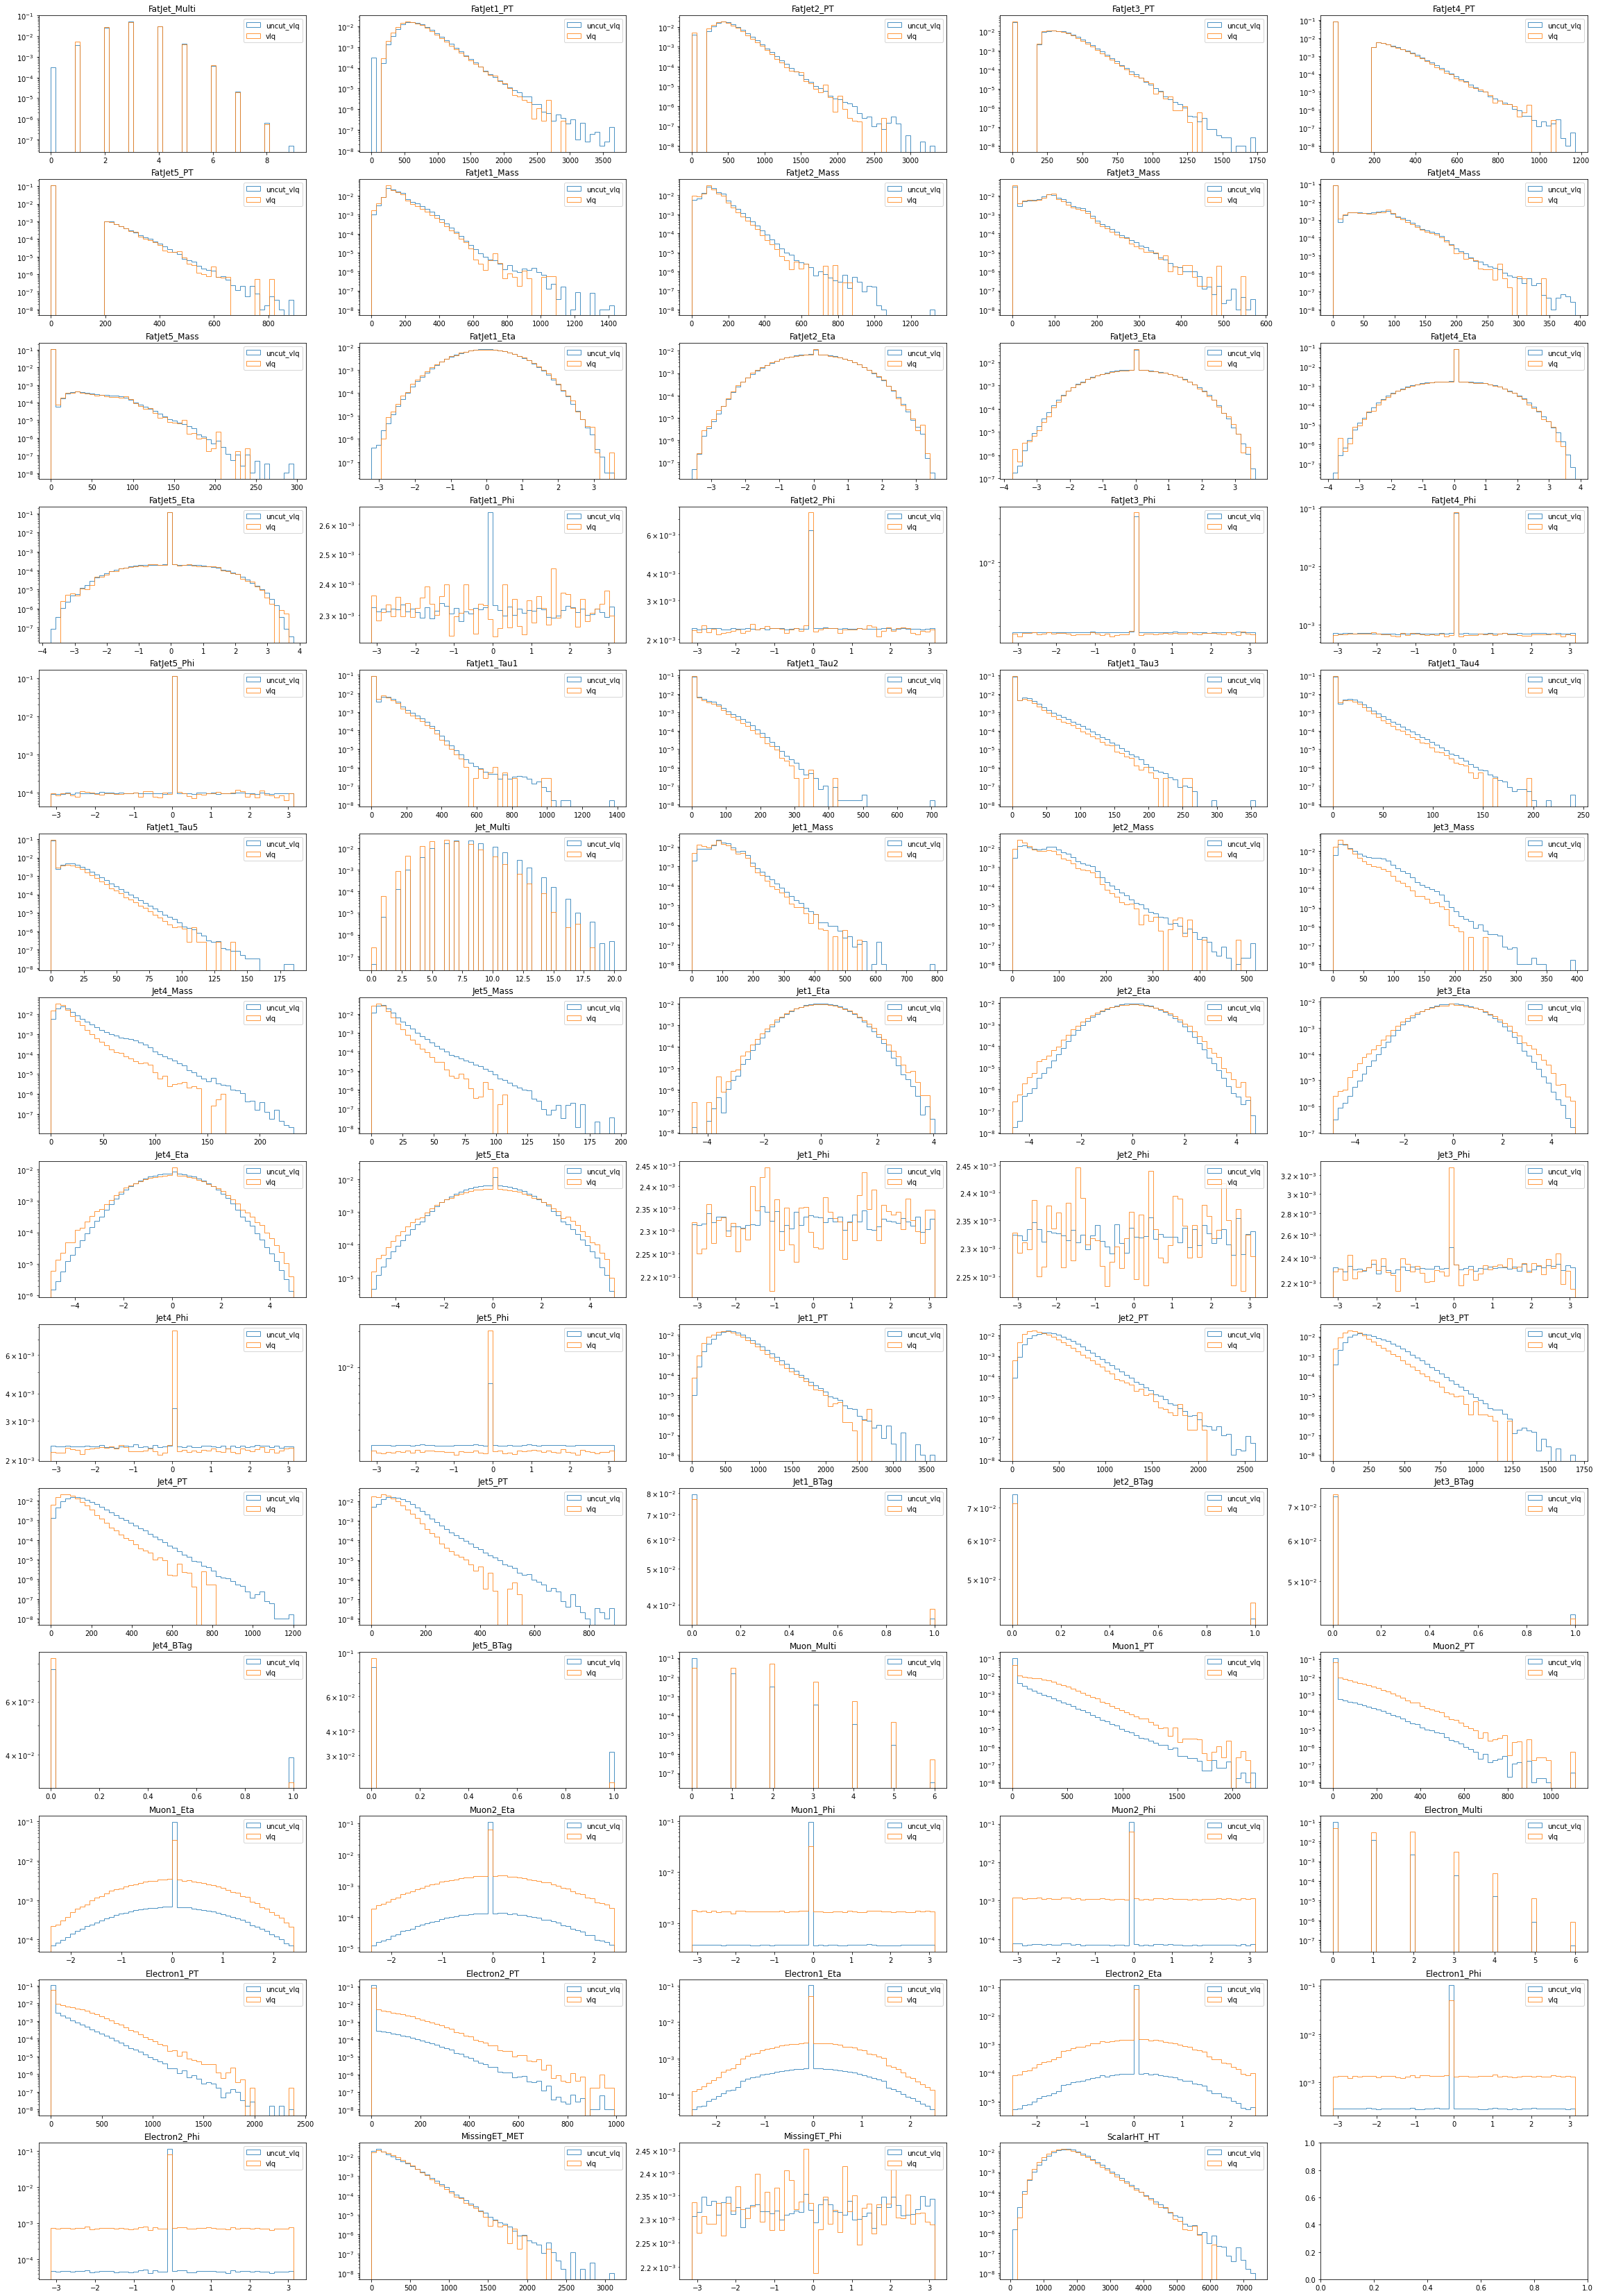

In [12]:
# Adjustment variables
num_cols, bins = 5, 50

# Create plots
num_rows = int(np.ceil((len(list(vlq.columns)) - 2) / num_cols))
fig, axs = plt.subplots(num_rows, num_cols, figsize=(40, 60))

# Iterate and plot the data
ignore_cols = ["gen_weights", "Label", "Sample"]
for i, column in tqdm(enumerate(vlq.columns), total=len(list(vlq.columns)), desc="Plotting"):
    if vlq.columns[i] not in ignore_cols:
        # Define histogram range
        hist_min = min(vlq[column].min(), uncut_vlq[column].min())
        hist_max = max(vlq[column].max(), uncut_vlq[column].max())
        hist_range = (hist_min, hist_max)

        # Plot data
        row, col = int(i/num_cols), i%num_cols
        axs[row, col].set_title(vlq.columns[i])
        axs[row, col].hist(uncut_vlq[column], bins=50, label="uncut_vlq", alpha=0.8, range=hist_range,
                           weights=uncut_vlq["gen_weights"], histtype='step')
        axs[row, col].hist(vlq[column], bins=50, label="vlq", alpha=0.8, range=hist_range,
                           weights=vlq["gen_weights"], histtype='step')
        axs[row, col].set_yscale("log")
        axs[row, col].legend()

plt.savefig("plots/UncutVLQ_vs_VLQ_distributions.png", dpi=500)
plt.show()